In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
df = pd.read_csv('DNS_datastore_backup.csv', index_col=0)

def get_xy(df):
    features = list(df.columns)[8:]
    x = np.array(df.loc[:,features].fillna(0))
    y = np.array(df['Label'])
    return x, y

x, y = get_xy(df)

In [3]:
mu = 0
sigma = (0.03 * x.mean(axis=0))
noise = np.random.normal(mu, sigma, size=x.shape)

x = x + noise

In [4]:
source_dict = {path: i for i, path in enumerate(df['Source Path'].unique())}
groups = df['Source Path'].map(source_dict)

<AxesSubplot:title={'center':'StratifiedKFold'}, xlabel='Sample index', ylabel='CV iteration'>

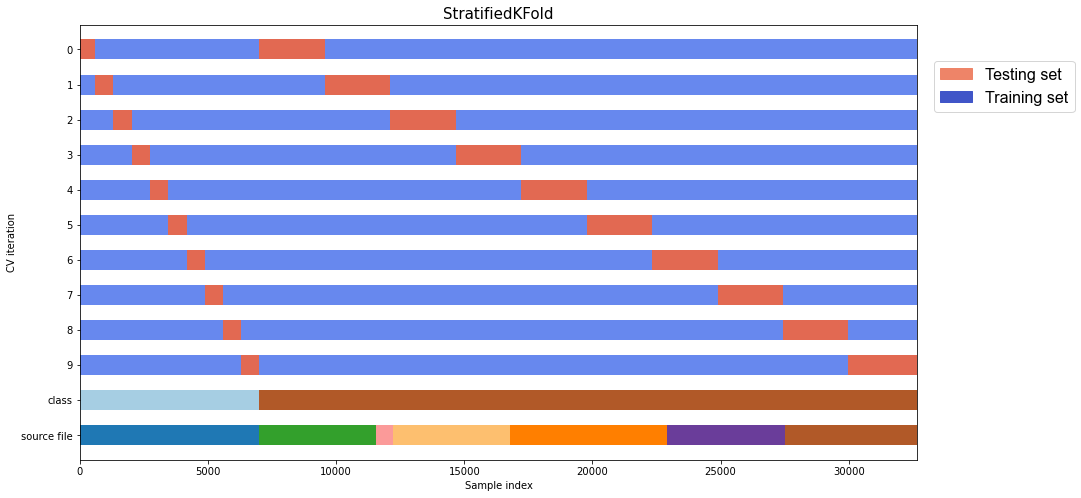

In [5]:
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, group, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(figsize=(15, 8))
    lw = 200/n_splits
    font = {'family':'arial', 'size':16}
    plt.rc('font', **font)
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['class', 'source file']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration", 
           ylim=[n_splits+2.2, -.2], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    return ax


n_splits=10
cv = StratifiedKFold(n_splits)
plot_cv_indices(cv, x, y, groups, n_splits)

In [ ]:
cv = StratifiedKFold(n_splits, n_repeats=10)
plot_cv_indices(cv, x, y, groups, n_splits)

In [6]:
rf_test = RandomForestClassifier(
    n_estimators=10,
    max_features=5,
    min_samples_leaf= 1,
    min_samples_split= 2,
    max_depth=5,
    n_jobs=-1,
    random_state=None)

In [7]:
def plot_search(p, name, score='accuracy', model=rf_test, x=x, y=y):
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=p, 
                               scoring=['accuracy','f1'],
                               return_train_score=True,
                               refit=False, 
                               cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10),
                               n_jobs=-1, verbose=1)
    grid_search.fit(x, y)
    

    param_name = 'param_%s' % list(p.keys())[0]

    # Extract information from the cross validation model
    train_means = grid_search.cv_results_['mean_train_'+score]*100
    train_stds  = grid_search.cv_results_['std_train_'+score]*100
    test_means  = grid_search.cv_results_['mean_test_'+score]*100
    test_stds   = grid_search.cv_results_['std_test_'+score]*100
    time_means  = grid_search.cv_results_['mean_fit_time']
    time_stds   = grid_search.cv_results_['std_fit_time']
    
    param_values = list(grid_search.cv_results_[param_name])
    
    font = {'family':'arial', 'size':16}
    plt.rc('font', **font)
    
    # Plot the means over the parameter
    plt.subplots(1, 2, figsize=(18, 8))
    plt.subplot(121)
    plt.plot(param_values, train_means, 'b-', label = 'train')
    plt.fill_between(param_values, train_means-train_stds, train_means+train_stds, alpha=0.3, color='b')
    plt.plot(param_values, test_means, 'g-', label = 'test')
    plt.fill_between(param_values, test_means-test_stds, test_means+test_stds, alpha=0.3, color='g')
    
    #plt.ylim(ymin = 0.94, ymax = 1)
    plt.autoscale()
    plt.legend(loc='lower right')
    plt.xlabel(name)
    plt.ylabel(score+' (%)')
    #plt.title('%s vs %s' % (score,name))
    
    plt.subplot(122)
    plt.plot(param_values, time_means, 'r-')
    plt.fill_between(param_values, time_means-time_stds, time_means+time_stds, alpha=0.2, color='r')
    plt.ylim(ymin = 0.0, ymax = max(list(time_means+time_stds)))
    plt.xlabel(name)
    plt.ylabel('train time (sec)')
    #plt.title('training time vs %s' % name)
    
    #return grid_search.cv_results_
    

Fitting 100 folds for each of 50 candidates, totalling 5000 fits
Wall time: 6min 30s


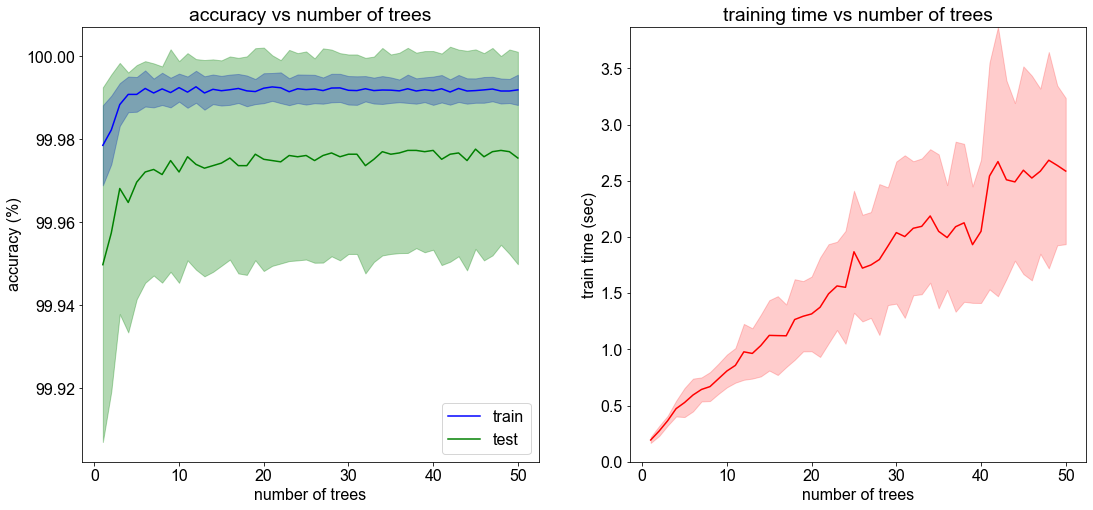

In [8]:
%%time
plot_search({'n_estimators':range(1,51)}, 'number of trees')

Fitting 100 folds for each of 15 candidates, totalling 1500 fits
Wall time: 47.3 s


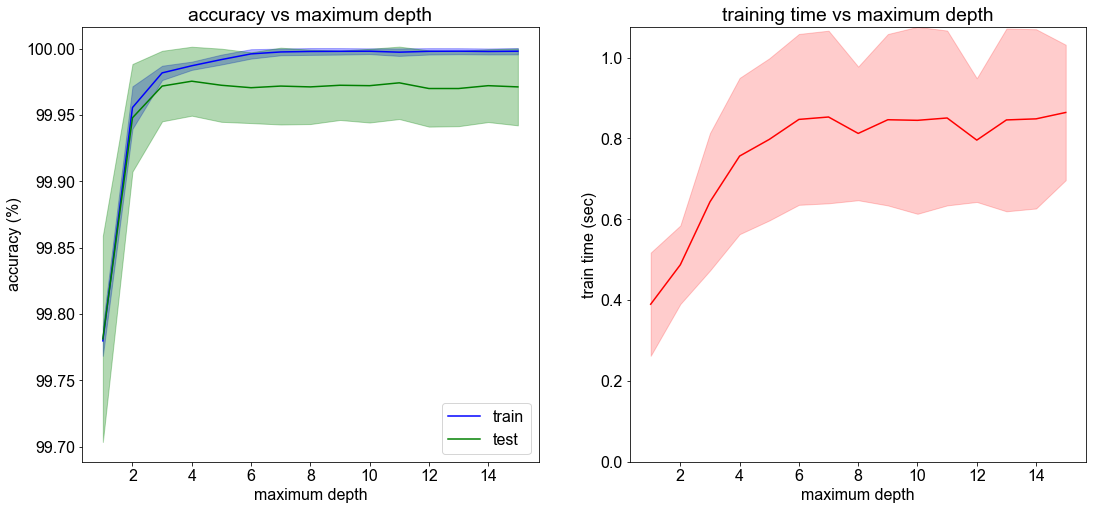

In [9]:
%%time
plot_search({'max_depth': range(1,x.shape[1]+1)}, 'maximum depth')

Fitting 100 folds for each of 15 candidates, totalling 1500 fits
Wall time: 1min 7s


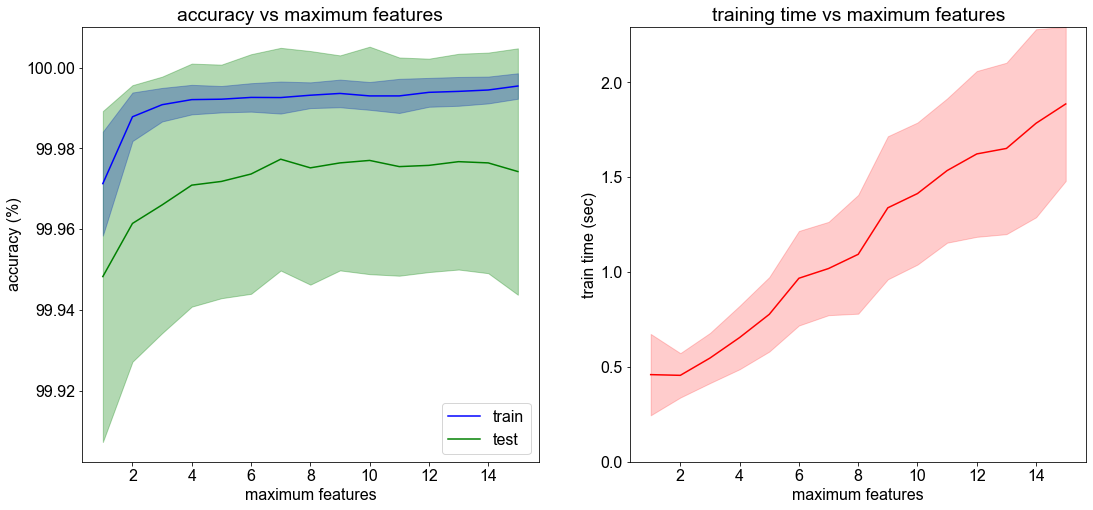

In [10]:
%%time
plot_search({'max_features': range(1,x.shape[1]+1)}, 'maximum features')

Fitting 100 folds for each of 49 candidates, totalling 4900 fits


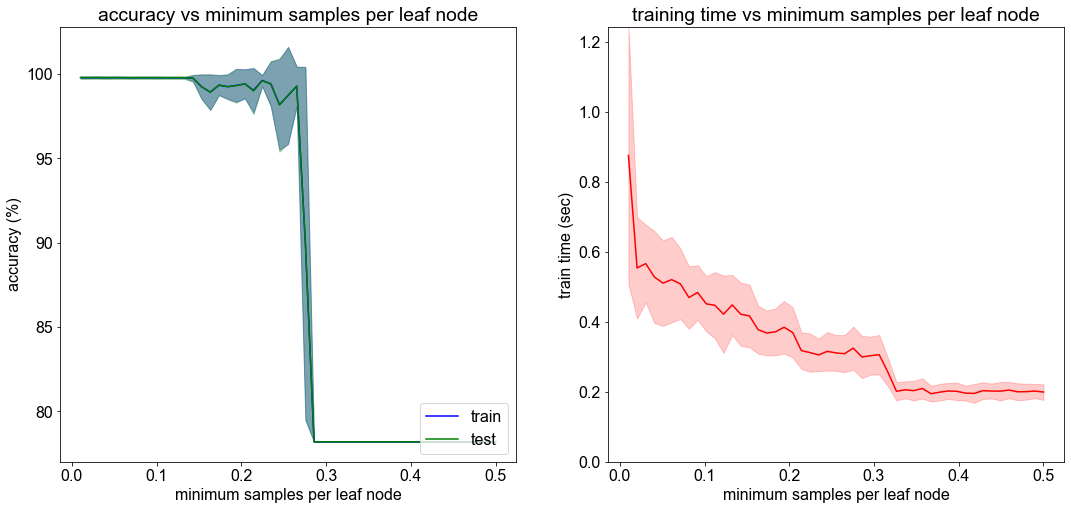

In [11]:
plot_search({'min_samples_leaf': np.linspace(0,0.5,50)[1:]}, 'minimum samples per leaf node')

Fitting 100 folds for each of 49 candidates, totalling 4900 fits
Wall time: 1min 44s


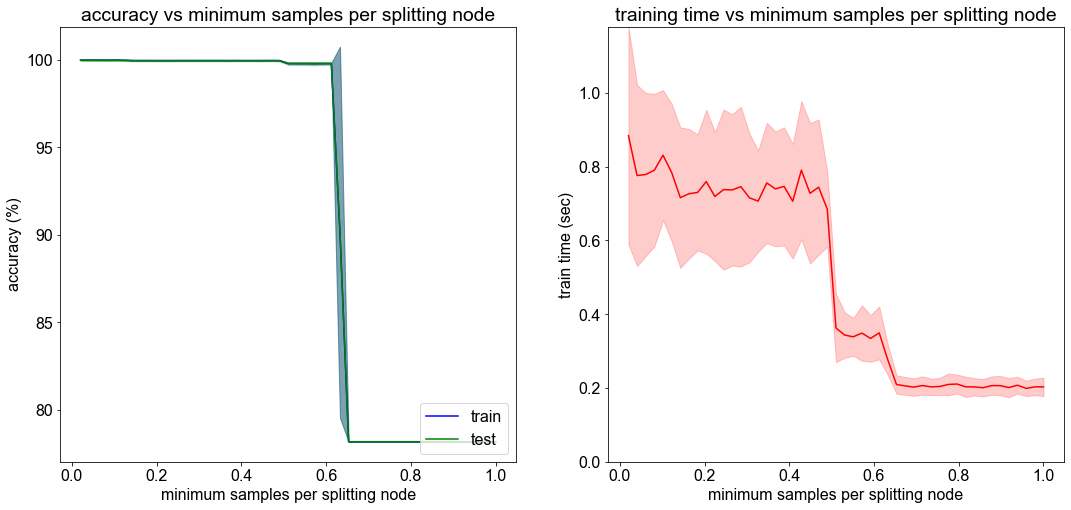

In [12]:
%%time
plot_search({'min_samples_split': np.linspace(0,1,50)[1:]}, 'minimum samples per splitting node')

In [13]:
# decreasing the difference between benign and malicious data to anticipate future attacks,
# in which the attack may be harder to find

def worsen(df,times):
    for i in range(times):
        df.iloc[:,9:] = (df.iloc[:,9:]+df.iloc[:,9:].mean(axis=0))/2
    return df

In [14]:
df3 = worsen(df,3)
x3, y3 = get_xy(df3)

Fitting 100 folds for each of 50 candidates, totalling 5000 fits
Wall time: 2min 53s


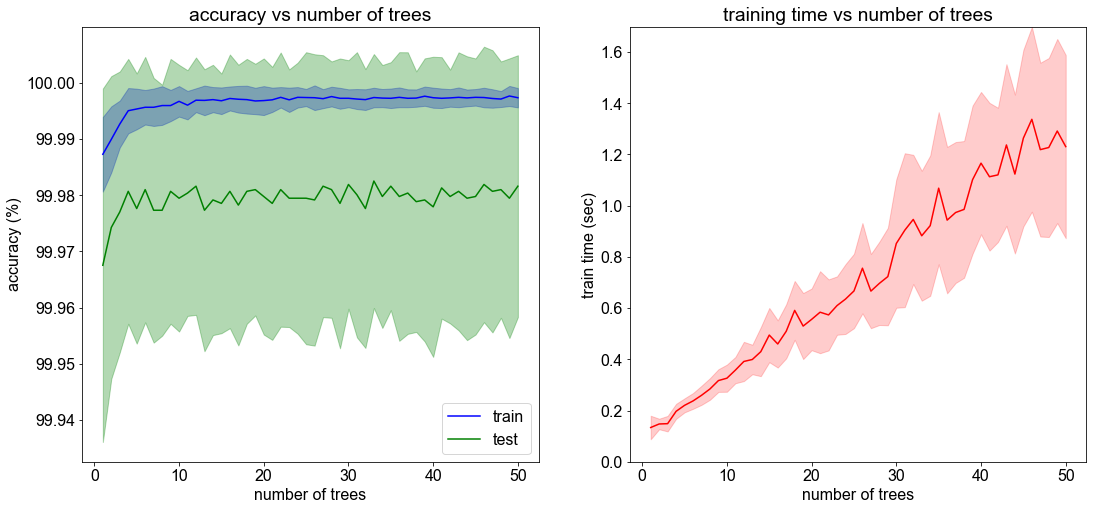

In [15]:
%%time
plot_search({'n_estimators':range(1,51)}, 'number of trees', x=x3, y=y3)

Fitting 100 folds for each of 50 candidates, totalling 5000 fits


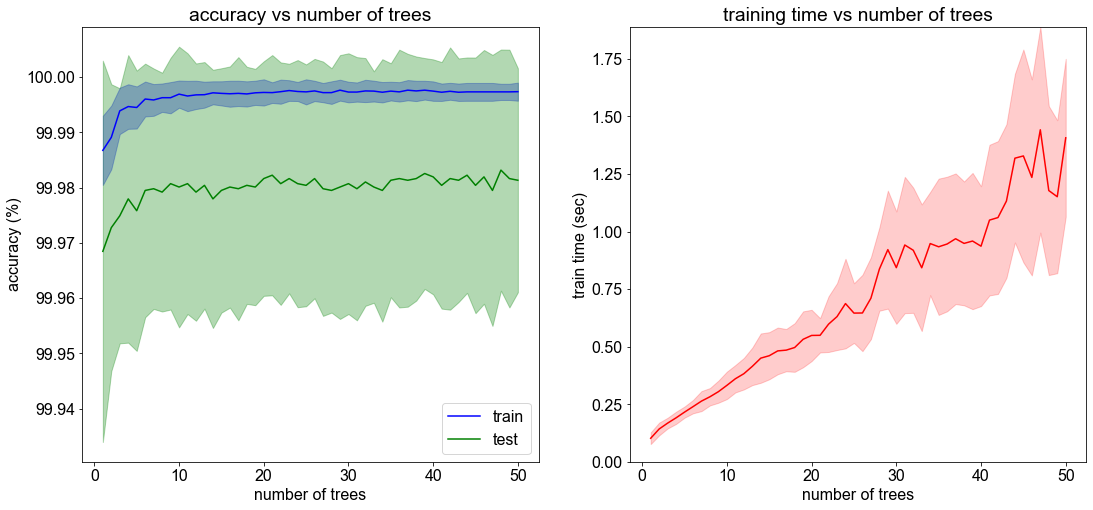

In [16]:
df4 = worsen(df,4)
x4, y4 = get_xy(df4)
plot_search({'n_estimators':range(1,51)}, 'number of trees', x=x4, y=y4)

#### Chosen model

In [17]:
#Chosen parameters:

rf_tuned = RandomForestClassifier(
    n_estimators=12,
    max_features=3,
    min_samples_leaf= 0.05,
    min_samples_split= 0.1,
    max_depth=3,
    n_jobs=-1,
    random_state=None)



In [31]:
def mean_cm(rf, x, y):
    
    cms_list = []
    kf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)
    
    for train_index, test_index in kf.split(x, y):

        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf.fit(x_train, y_train)
        cm = confusion_matrix(y_test, rf.predict(x_test))
        cms_list.append(cm)
    
    mean_cm = np.mean(cms_list, axis=0)

    names = ['TN','FP','FN','TP']
    counts = ['{0:0.3f}'.format(value) for value in mean_cm.flatten()]
    percents = ['{0:.3%}'.format(value) for value in mean_cm.flatten()/np.sum(mean_cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percents)]
    labels = np.asarray(labels).reshape(2,2)
    plt.title('Mean Confusion Matrix')
    fig = sb.heatmap(mean_cm, annot=labels, fmt='', cmap='Blues', cbar=False).get_figure()

    TN, FP, FN, TP =  [floax for x in np.asarray(mean_cm).reshape(-1)]
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    metrics = pd.DataFrame(columns=['Evaluation Metric (other names)','Equation','Value'])
    metrics.loc['Accuracy',:] = ['', 'TN+TP / total', '%.3f%%' %((TN+TP)/(TN+TP+FN+FP)*100)]
    metrics.loc['True Positive Rate',:] = ['Sensitivity, Recall', 'TP/(TP+FN)', '%.3f%%' %(recall*100)]
    metrics.loc['True Negative Rate',:] = ['Specificity', 'TN/(TN+FN)', '%.3f%%' %(TN/(TN+FN)*100)]
    metrics.loc['False Positive Rate',:] = ['Fall-Out', 'FP/(TN+FN)', '%.3f%%' %(FP/(TN+FN)*100)]
    metrics.loc['False Negative Rate',:] = ['Miss Rate', 'TN/(FN+TP)', '%.3f%%' %(FN/(FN+TP)*100)]
    metrics.loc['Positive Predictive Value',:] = ['Precision', 'TP/(TP+FP)', '%.3f%%' %(precision*100)]
    metrics.loc['False Discovery Rate',:] = ['', 'FP/(FP+TP)', '%.3f%%' %(FP/(FP+TP)*100)]
    metrics.loc['F-1 Score',:] = ['', '2*(Recall*Precision) /(Recall+Precision)', \
                                  '%.3f%%' %(2*(recall*precision)/(recall+precision)*100)]
    display(metrics)


,Evaluation Metric (other names),Equation,Value
Accuracy,,TN+TP / total,99.847%
True Positive Rate,"Sensitivity, Recall",TP/(TP+FN),100.000%
True Negative Rate,Specificity,TN/(TN+FN),100.000%
False Positive Rate,Fall-Out,FP/(TN+FN),0.709%
False Negative Rate,Miss Rate,TN/(FN+TP),0.000%
Positive Predictive Value,Precision,TP/(TP+FP),99.804%
False Discovery Rate,,FP/(FP+TP),0.196%
F-1 Score,,2*(Recall*Precision) /(Recall+Precision),99.902%


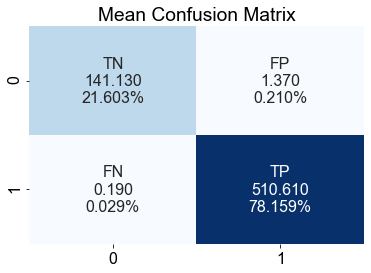

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)
rf_tuned.fit(x_train ,y_train)
mean_cm(rf_tuned, x_test, y_test)

#### Comparing results

In [ ]:
def v_scores(model, x=x, y=y):
    acc = []
    F1 = []
    
    sigma = (0.03 * x.mean(axis=0))
    
    for i in range(10):
        noise = np.random.normal(0, sigma, size=x.shape)
        xn = x + noise
        cv_results = cross_validate(model, xn, y, 
                                    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=10), 
                                    scoring=('accuracy', 'f1'))
        
        acc = acc + list(cv_results['test_accuracy'])
        F1  = F1  + list(cv_results['test_f1'])
    
    return acc, F1

In [ ]:
acc_scores = pd.DataFrame()
F1_scores = pd.DataFrame()

In [ ]:
%%time

# Random Forest, tuned model
rf_tuned.fit(x,y)
acc_scores['RF tuned'], F1_scores['RF tuned'] = v_scores(rf_tuned)

In [ ]:
%%time

# Random Forest, base model
acc_scores['RF base'], F1_scores['RF base'] = v_scores(rf_test)

In [ ]:
%%time

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
acc_scores['DT'], F1_scores['DT'] = v_scores(dt)

In [ ]:
%%time

from sklearn.svm import SVC
svm = SVC()
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(0,1)).fit(x3)
x_scaled = scaling.transform(x3)
acc_scores['SVM'], F1_scores['SVM'] = v_scores(svm, x=x_scaled)

In [ ]:
%%time

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
acc_scores['KNN'], F1_scores['KNN'] = v_scores(neigh)

In [ ]:
%%time
from sklearn.linear_model import SGDClassifier
SDGC = SGDClassifier()
acc_scores['SDGC'], F1_scores['SDGC'] = v_scores(SDGC)

In [ ]:
ind = np.arange(acc_scores.shape[1])
width = 0.35

fig, ax = plt.subplots(figsize=(10, 8))
acc_bars = ax.bar(ind-width/2, list(acc_scores.mean(axis=0)), width, yerr=list(acc_scores.std(axis=0)), label='Accuracy',
                 error_kw=dict(capsize=5, lw=0.5, capthick=0.5), color='#0099C4', ecolor='navy')
F1_bars = ax.bar(ind+width/2, list(F1_scores.mean(axis=0)), width, yerr=list(F1_scores.std(axis=0)), label='F1-score',
                 error_kw=dict(capsize=5, lw=0.5, capthick=0.5), color='#96D9EE', ecolor='navy') 
plt.ylim(ymin = 0.87,ymax=1.05)
#plt.autoscale()
plt.ylabel('accuracy')

ax.set_xticks(ind)
ax.set_xticklabels(acc_scores.columns)


plt.legend(loc = 'lower left')
def autolabel(labels, xpos='center'):
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for label in labels:
        height = label.get_height()
        ax.annotate('{:.3%}'.format(height*100),
                    xy=(label.get_x() + label.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both dilabelions
                    ha=ha[xpos], va='bottom',
                    rotation=90,
                    fontsize=14)


autolabel(acc_bars, "left")
autolabel(F1_bars, "right")
plt.tight_layout()
fig.savefig('Model_Metrics/Compared_Performances.png', dpi=300)